In [7]:
#!/usr/bin/env python3

import glob
import os
import pprint
import traceback

import click

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Extraction function
def tflog2pandas(path: str) -> pd.DataFrame:
    """convert single tensorflow log file to pandas DataFrame
    Parameters
    ----------
    path : str
        path to tensorflow log file
    Returns
    -------
    pd.DataFrame
        converted dataframe
    """
    DEFAULT_SIZE_GUIDANCE = {
        "compressedHistograms": 1,
        "images": 1,
        "scalars": 0,  # 0 means load all
        "histograms": 1,
    }
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path, DEFAULT_SIZE_GUIDANCE)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data


def many_logs2pandas(event_paths):
    all_logs = pd.DataFrame()
    for path in event_paths:
        log = tflog2pandas(path)
        if log is not None:
            if all_logs.shape[0] == 0:
                all_logs = log
            else:
                all_logs = all_logs.append(log, ignore_index=True)
    return all_logs


@click.command()
@click.argument("logdir-or-logfile")
@click.option(
    "--write-pkl/--no-write-pkl", help="save to pickle file or not", default=False
)
@click.option(
    "--write-csv/--no-write-csv", help="save to csv file or not", default=True
)
@click.option("--out-dir", "-o", help="output directory", default=".")
def main(logdir_or_logfile: str, write_pkl: bool, write_csv: bool, out_dir: str):
    """This is a enhanced version of
    https://gist.github.com/ptschandl/ef67bbaa93ec67aba2cab0a7af47700b
    This script exctracts variables from all logs from tensorflow event
    files ("event*"),
    writes them to Pandas and finally stores them a csv-file or
    pickle-file including all (readable) runs of the logging directory.
    Example usage:
    # create csv file from all tensorflow logs in provided directory (.)
    # and write it to folder "./converted"
    tflogs2pandas.py . --write-csv --no-write-pkl --o converted
    # creaste csv file from tensorflow logfile only and write into
    # and write it to folder "./converted"
    tflogs2pandas.py tflog.hostname.12345 --write-csv --no-write-pkl --o converted
    """
    pp = pprint.PrettyPrinter(indent=4)
    if os.path.isdir(logdir_or_logfile):
        # Get all event* runs from logging_dir subdirectories
        event_paths = glob.glob(os.path.join(logdir_or_logfile, "event*"))
    elif os.path.isfile(logdir_or_logfile):
        event_paths = [logdir_or_logfile]
    else:
        raise ValueError(
            "input argument {} has to be a file or a directory".format(
                logdir_or_logfile
            )
        )
    # Call & append
    if event_paths:
        pp.pprint("Found tensorflow logs to process:")
        pp.pprint(event_paths)
        all_logs = many_logs2pandas(event_paths)
        pp.pprint("Head of created dataframe")
        pp.pprint(all_logs.head())

        os.makedirs(out_dir, exist_ok=True)
        if write_csv:
            print("saving to csv file")
            out_file = os.path.join(out_dir, "all_training_logs_in_one_file.csv")
            print(out_file)
            all_logs.to_csv(out_file, index=None)
        if write_pkl:
            print("saving to pickle file")
            out_file = os.path.join(out_dir, "all_training_logs_in_one_file.pkl")
            print(out_file)
            all_logs.to_pickle(out_file)
    else:
        print("No event paths have been found.")



In [3]:
df = tflog2pandas('/home/mrudolph/documents/fuzzrl/rl_train/tb_log/FuzzGym-v0/PPO_1/events.out.tfevents.1682476294.hopper.42987.0')

In [70]:
path = '/home/mrudolph/documents/fuzzrl/rl_train/tb_log/FuzzGym-v0/PPO_1/events.out.tfevents.1682476294.hopper.42987.0'
path9 = '/home/mrudolph/documents/fuzzrl/rl_train/tb_log/FuzzGym-v0/PPO_9/events.out.tfevents.1682479184.hopper.46580.0'
path10 = '/home/mrudolph/documents/fuzzrl/rl_train/tb_log/FuzzGym-v0/PPO_10/events.out.tfevents.1682494996.hopper.53589.0'
path11 = '/home/mrudolph/documents/fuzzrl/rl_train/tb_log/FuzzGym-v0/PPO_11/events.out.tfevents.1682520177.hopper.58458.0'
path12 = '/home/mrudolph/documents/fuzzrl/rl_train/tb_log/FuzzGym-v0/PPO_12/events.out.tfevents.1682532826.hopper.61640.0'
paths = [path9, path10, path11, path12]
ids = [9,10,11,12]
dfs = []
df_all = df9
for i, path in enumerate(paths):
    df = tflog2pandas(path)
    df['id'] = ids[i]
    df['time'] = [k for k in range(df.shape[0])]
    dfs.append(df)
    
df_all = pd.concat(dfs)

In [ ]:
sns.lineplot(data =df_all.query("metric == 'rollout/ep_rew_mean' and id==10"), x="step", y="value")
plt.xlabel('Training Step')
plt.ylabel('Cumulative Episodic Reward')
plt.title('Parameter Fuzzer Reward')

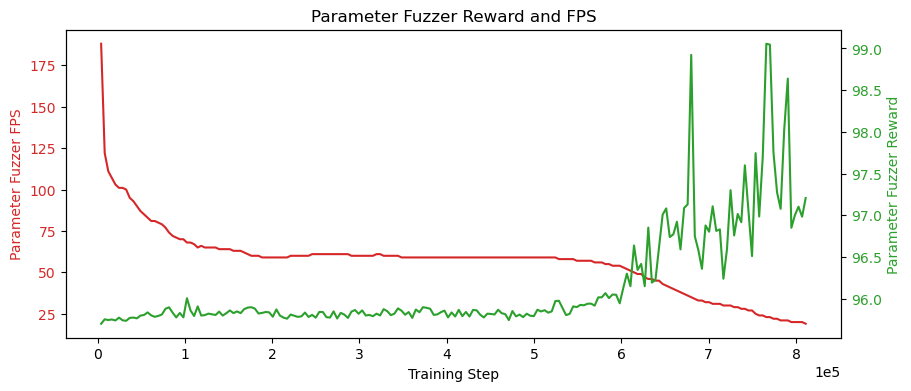

In [109]:
fps = df_all.query("metric=='time/fps' and id==10")
rew = df_all.query("metric=='rollout/ep_rew_mean' and id==10")
normalfps = (fps['value'].values)# - np.min(fps['value'].values)) / (np.max(fps['value'].values) - np.min(fps['value'].values))
normalrew = (rew['value'].values)# - np.min(rew['value'].values)) / (np.max(rew['value'].values) - np.min(rew['value'].values))
step = fps['step'].values

plt.rcParams['figure.figsize'] = [10, 4]
# Creating plot with dataset_1
fig, ax1 = plt.subplots()
 
color = 'tab:red'
ax1.set_xlabel('Training Step')
ax1.set_ylabel('Parameter Fuzzer FPS', color = color)
ax1.plot(step, normalfps, color = color)
ax1.tick_params(axis ='y', labelcolor = color)
 
# Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx()
 
color = 'tab:green'
ax2.set_ylabel('Parameter Fuzzer Reward', color = color)
ax2.plot(step, normalrew, color = color)
ax2.tick_params(axis ='y', labelcolor = color)

ax1.ticklabel_format(style='sci',scilimits=(-3,4),axis='x')

# Adding title
plt.title('Parameter Fuzzer Reward and FPS')
 
# Show plot
plt.show()

In [21]:
df['metric'].unique()

array(['rollout/ep_len_mean', 'rollout/ep_rew_mean', 'time/fps',
       'train/approx_kl', 'train/clip_fraction', 'train/clip_range',
       'train/entropy_loss', 'train/explained_variance',
       'train/learning_rate', 'train/loss', 'train/policy_gradient_loss',
       'train/std', 'train/value_loss', 'eval/mean_ep_length',
       'eval/mean_reward'], dtype=object)

In [1]:
import numpy as np


In [2]:
a=np.load('/home/mrudolph/documents/fuzzrl/rl_train/logs/ppo/FuzzGym-v0_1/evaluations.npz')

In [5]:
list(a.keys())

['timesteps', 'results', 'ep_lengths']